In [1]:
import numpy as np
from numpy.random import seed
seed(440232650)
from tensorflow import set_random_seed
set_random_seed(440232650)
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
import tensorflow
warnings.filterwarnings('ignore') 
import os, random, cv2, h5py
from glob import glob
from sklearn.preprocessing import OneHotEncoder
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc, jaccard_score

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from keras.layers import Input, Dropout, Flatten, Dense, AveragePooling2D, Conv2D, GlobalAveragePooling2D
from keras.optimizers import Adam
import np_utils
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, CSVLogger

/home/s188/sarah_environments/sarah_thesis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/s188/sarah_environments/sarah_thesis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/s188/sarah_environments/sarah_thesis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/s188/sarah_envir

In [2]:
import os

In [3]:
import segmentation_models as sm
from segmentation_models import Unet
#from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss

#from segmentation_models.losses import DiceLoss
from segmentation_models.metrics import iou_score

Segmentation Models: using `keras` framework.


In [4]:
#weights = [0.4, 0.6, 0.5, 1]

In [5]:
IOU = sm.metrics.IOUScore() #iou is also known as the jaccard score
Fscore = sm.metrics.FScore() #also known as dice coeff

#loss = sm.losses.DiceLoss(class_weights=weights)
loss = sm.losses.DiceLoss()

learning_rate = 0.0001
#lr='1e-4'
#loss = sm.losses.CategoricalCELoss(class_weights = weights)
#loss_name = 'DiceLoss'

metrics = [IOU, Fscore]

In [6]:
opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [7]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [8]:
class_dict = {0:'BG', 1:'H',2:'L',3:'C'}

In [9]:
image_size = 256
#batch_size = 8
#epochs = 100
#backbone = 'vgg16'

In [10]:
save_path = 'JSRT_test_uncropped_training_aug_uncropped_tl_weights_1e-3'

In [11]:
img_path = 'JSRT Converted Images'
mask_path = 'JSRTMasks_4'

In [12]:
def test_gen(img_folder, mask_folder, batch_size=22, image_size=256, classes=4):
    c=0
    n=os.listdir(img_folder)
    n.sort() #always evaluate in the same order 
    #remove shuffling
    while (True):
        img = np.zeros((batch_size, image_size, image_size, 1)).astype('float')
        mask = np.zeros((batch_size, image_size, image_size, classes)).astype('float')
        
        for i in range(c, c+batch_size):
            
            train_img = cv2.imread(os.path.join(img_folder,n[i]), cv2.IMREAD_GRAYSCALE)
            train_img = cv2.equalizeHist(train_img) 
            train_img = cv2.bitwise_not(train_img)/255.
            train_img = cv2.resize(train_img, (image_size, image_size))
            train_img = train_img.reshape([image_size, image_size,1])
            
            img[i-c] = train_img #add to array img[0] img [1] etc
            
            train_mask = cv2.imread(os.path.join(mask_folder,n[i]), cv2.IMREAD_GRAYSCALE)
            train_mask = cv2.resize(train_mask, (image_size, image_size))
            train_mask = train_mask.ravel()
            train_mask = to_categorical(train_mask, num_classes=classes)
            train_mask = train_mask.reshape([image_size, image_size, classes])
            
            mask[i-c] = train_mask
            
        c+=batch_size
        if (c+batch_size>=len(os.listdir(img_folder))):
            c=0
        
        yield img, mask

In [13]:
test_generator = test_gen(img_path, mask_path, image_size=image_size, batch_size=22)

In [14]:
base_model = Unet(backbone_name='vgg16', encoder_weights='imagenet', classes=4, activation = 'softmax', encoder_freeze = True)

inp = Input(shape=(image_size, image_size, 1)) # need new input layer for 1-channel medical data

l1 = Conv2D(3, (1, 1))(inp) # map single channel to RGB channels
out = base_model(l1)

model = Model(inp, out, name=base_model.name)

In [15]:
#model = Unet(backbone_name='vgg16', encoder_weights=None, classes=4, activation = 'softmax', encoder_freeze = False, input_shape=(image_size, image_size, 1))


In [15]:
model.load_weights('Weights/Unet_b8_e100_vgg16_1e-3_aug_tl_weights_uncropped.h5')

In [16]:
model.compile(opt, loss=loss, metrics=metrics)

In [17]:
#model.evaluate_generator(test_generator, steps=1)

In [18]:
model.metrics_names

['loss', 'iou_score', 'f1-score']

In [19]:
predictions = model.predict_generator(test_generator, steps=242/22)

In [20]:
image_names = os.listdir(img_path)
image_names.sort()

In [21]:
image_names = os.listdir(img_path)
image_names.sort()
#predictions = model.predict_generator(test_generator, steps=242/22)
ypred = np.argmax(predictions, axis=-1)

In [22]:
def plot_pred(index, predictions = ypred, save=False):
    img = cv2.imread(os.path.join(img_path,image_names[index]), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (image_size, image_size))   
    
    target = cv2.imread(os.path.join(mask_path, image_names[index]), cv2.IMREAD_GRAYSCALE)
    target = cv2.resize(target, (image_size, image_size))
    
    scores = jaccard_score(target.ravel(), ypred[index].ravel(), average=None)
    
    fig = plt.figure(frameon=False)
    im1 = plt.imshow(img, cmap='gray')
    im2 = plt.imshow(ypred[index], cmap = 'plasma', alpha=0.4)
    plt.axis('off')
    plt.annotate(f'IoU Heart: {round(scores[1]*100,2)}, Lungs: {round(scores[2]*100,2)},\n Clavicles: {round(scores[3]*100,2)}',(image_size*0.1, image_size*0.95), color='white')
    
    if save == True:
        plt.savefig(f'Figures/JSRTFigs/{save_path}_{image_names[index]}.png')
    
    plt.show()

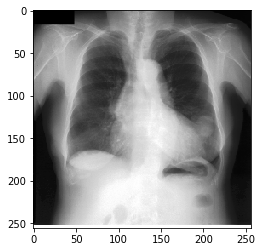

In [23]:
img = cv2.imread(os.path.join(img_path,image_names[1]), cv2.IMREAD_GRAYSCALE)
img = cv2.equalizeHist(img) 
img = cv2.bitwise_not(img)
img = cv2.resize(img, (image_size, image_size))
fig = plt.figure(frameon=False)
im1 = plt.imshow(img, cmap='gray')
plt.show()

In [24]:
scores = np.zeros((242,4))


for i in range(len(ypred)):
    img = cv2.imread(os.path.join(img_path,image_names[i]), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (image_size, image_size))
    target = cv2.imread(os.path.join(mask_path, image_names[i]), cv2.IMREAD_GRAYSCALE)
    target = cv2.resize(target, (image_size, image_size))
    a,b,c,d = jaccard_score(target.ravel(), ypred[i].ravel(), average=None)
    scores[i,0] = a
    scores[i,1] = b
    scores[i,2] = c
    scores[i,3] = d
    

In [25]:
def plot_truth(index, save=False):
    img = cv2.imread(os.path.join(img_path,image_names[index]), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (image_size, image_size))   
    
    target = cv2.imread(os.path.join(mask_path, image_names[index]), cv2.IMREAD_GRAYSCALE)
    target = cv2.resize(target, (image_size, image_size))
    
    fig = plt.figure(frameon=False)
    im1 = plt.imshow(img, cmap='gray')
    im2 = plt.imshow(target, cmap = 'plasma', alpha=0.4)
    plt.axis('off')
    
    if save == True:
        plt.savefig(f'Figures/JSRTFigs/truth_{image_names[index]}.png')
    
    plt.show()

In [26]:
#plot_truth(49, save=True)

In [27]:
scores.mean(axis=0)

array([0.93452653, 0.79571783, 0.89514963, 0.76041784])

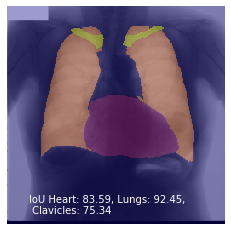

In [28]:
plot_pred(1, ypred, save=True)

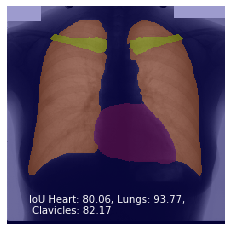

In [29]:
plot_pred(18, ypred, save=True)

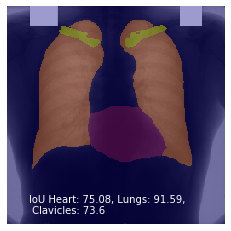

In [30]:
plot_pred(23, ypred, save=True)

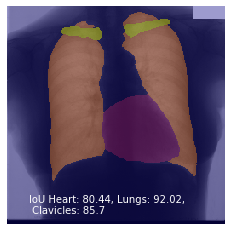

In [31]:
plot_pred(49, ypred, save=True)

In [17]:
masks = np.zeros((242,image_size, image_size, 4))


for i in range(242):
    target = cv2.imread(os.path.join(mask_path, image_names[i]), cv2.IMREAD_GRAYSCALE)
    target = cv2.resize(target, (image_size, image_size))
    target = target.ravel()
    target = to_categorical(target, num_classes=4)
    target = target.reshape([image_size, image_size, 4])
    masks[i] = target

In [18]:
means = masks.mean(axis=0)

In [19]:
meanpred = np.argmax(means, axis=-1)
meanpred.shape

(256, 256)